Задача.  
Используя МНК найти параметры объекта, уравнение которого имеет вид:  
$$y(i) = a_0+a_1x_1(i)+a_2x_2(i)+a_3x_3(i)+\eta(i)$$
$x_j(i) - вход\ объекта, j=1,2,3$  
$a_0,a_1,a_2 - оцениваемые\ параметры$  
$\eta(i)$ - шум измерений, имеет нормальное распределение с параметрами $D=2, M\{\eta\}=0$  
Оценку провести рекуррентным методом.  
$y(i)$ - выход объекта. 

#Данные

##Входы объекта

In [ ]:
import numpy as np

In [ ]:
x = np.array([[14.46, 14.30, 17.22, 13.85,16.27, 13.43, 18.01, 18.02, 12.64, 13.41, 13.22, 16.43, 18.06, 12.70, 11.70, 10.42, 16.60, 15.34, 17.40, 14.99],
              [2.064, 2.288, 2.381, 2.281, 3.267, 2.372, 3.071, 2.843, 2.630, 2.317, 2.564, 2.669, 2.294, 2.611, 2.595, 2.840, 2.454, 2.618, 2.379, 2.209],
              [6.711, 4.422, 8.492, 5.613, 5.321, 5.350, 6.667, 5.502, 6.086, 5.919, 3.714, 5.121, 4.933, 4.855, 5.709, 5.068, 6.341, 6.634, 7.789, 6.074]
              ])

In [ ]:
warn_example = np.array([[1,2,3],[4,5]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
N = len(x[0])
x=np.insert(arr=x, obj=0, values=np.full(shape=(N,), fill_value=1), axis=0)

In [ ]:
x.shape

(4, 20)

##Выходы объекта

In [ ]:
y = np.array([46.45, 43.01, 55.27, 43.96, 49.82, 42.69, 55.01, 52.88, 42.81, 43.66, 40.32, 49.00, 51.32, 40.90, 40.31, 37.07, 50.53, 48.84, 54.30, 47.02])

In [ ]:
y.shape

(20,)

##Визуализация входов и выходов

In [ ]:
from scipy.stats import norm
import matplotlib.pyplot as plt

In [ ]:
plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams["figure.dpi"] = 100


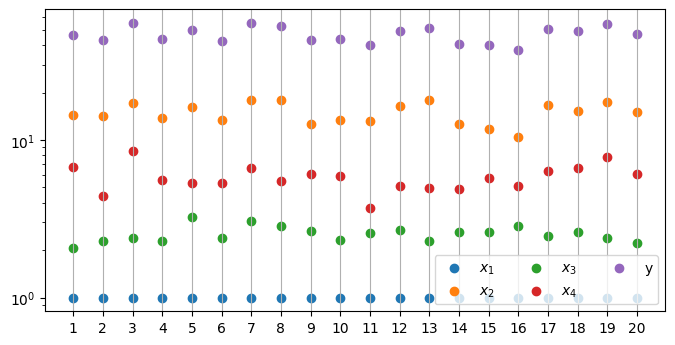

In [ ]:
measurement_n = np.linspace(1,N,N)
for i in range(len(x)):
  plt.scatter(measurement_n, x[i], label=r'$x_'+str(i+1)+'$')
plt.scatter(measurement_n,y, label ='y')
plt.xticks(measurement_n)
plt.grid(axis='x')
plt.yscale('log')
plt.legend(loc='lower right', ncol=3)
None

#Оценка параметров

In [2]:
#@title Реализация нерекуррентного МНК
def nonRecLS(U,R,y):
  Ut = np.transpose(U)
  UtR =  Ut.dot(R)
  UtRU = UtR.dot(U)
  UtRU_inv = np.linalg.inv(UtRU)
  UtRU_invUtR = (UtRU_inv.dot(Ut)).dot(R)
  return UtRU_invUtR.dot(y)

In [ ]:
nonRecLS(np.transpose(x),np.eye(N),y)

array([4.52942262, 1.99049039, 1.48374341, 1.50604236])

Реккурентный МНК
$$ \large \vec{\hat{c}_{LS}}(i+1) = \vec{\hat{c}_{LS}}(i) + K(i+1)(y(i)-\vec{u}^{T}(i)\vec{\hat{c}_{LS}}(i)) $$
$$ $$
$$ \large K(i+1) = P(i)\vec{u}(i)\frac{1}{\frac{1}{r(i)}+\vec{u}^{T}(i)P(i)\vec{u}(i)} $$
$$ $$
$$ \large P(i+1) = P(i) - \frac{1}{\frac{1}{r(i)}+\vec{u}^{T}(i)P(i)\vec{u}(i)}P(i)\vec{u}(i)\vec{u}^{T}(i)P(i) $$
$$P(0)= \lambda I $$

Замечания.  
- $P(i) = [U(i)^TR(i)^TU(i)]^{-1}$  
$var(\vec{c}-\hat{\vec{c}})=[U(i)^TU(i)]^{-1}\sigma_{\eta}^2, при\ R=I, D_{\eta}=\sigma_{\eta}^2I$  
А значит $P$  можно рассматривать в качестве меры неопределенности оценок
- $\Delta(P)=P(i+1)-P(i)\leq0 =>$ с увеличением количества наблюдений неопределенность уменьшается

In [1]:
#@title Реализация рекуррентного МНК
class RecurrentMLS:
 
    def __init__(self, lam):
        self.lam = lam
        self.c_estim_recMLS = np.array([])

    def fit(self, U, y, c0):
      self.c_estim_recMLS = np.zeros((len(y)+1,len(c0)))
      c_prev = c0.reshape(len(c0),1)
      self.c_estim_recMLS[0]=c0
      P_prev = self.lam*np.eye(len(U[0]))
      
      for i in range(len(y)):
        u_i = U[i].reshape(len(U[i]),1)
        K = np.matmul( P_prev, u_i )
        inv = np.matmul( np.transpose(u_i), P_prev )
        inv = np.matmul(inv,u_i)
        inv +=1
        inv = 1/inv
        K *= inv

        residual = y[i] - np.matmul(np.transpose(u_i),c_prev)
        c_curr = c_prev + np.matmul(K, residual)
        self.c_estim_recMLS[i+1]=c_curr.reshape(len(c_curr))

        P_curr = P_prev - np.matmul(K,np.transpose(u_i))*P_prev

        P_prev = P_curr
        c_prev = c_curr

    def get_coefs(self):
      return self.c_estim_recMLS

In [ ]:
exp = RecurrentMLS(100)
exp.fit(np.transpose(x),y,np.array([4.5, 2, 1.5, 1.5]))
fit_res = exp.get_coefs()[N]
fit_res

array([4.55697878, 1.99461917, 1.51727879, 1.51352144])

#Исследование зависимости оценки от числа измерений  
Сгенерируем выходы объекта на основе уравнения, заданного в условии, и оценок параметров, полученных нерекуррентным МНК

In [ ]:
N_arr = [20, 80, 300]
c = [4.52942262, 1.99049039, 1.48374341, 1.50604236]
c_len = len(c)

##Шум

In [ ]:
err_arr = []
for i in range(len(N_arr)):
  err_arr.append(norm.rvs(loc=0, scale=np.sqrt(2),size=N_arr[i]))
  print(len(err_arr[i]))  

20
80
300


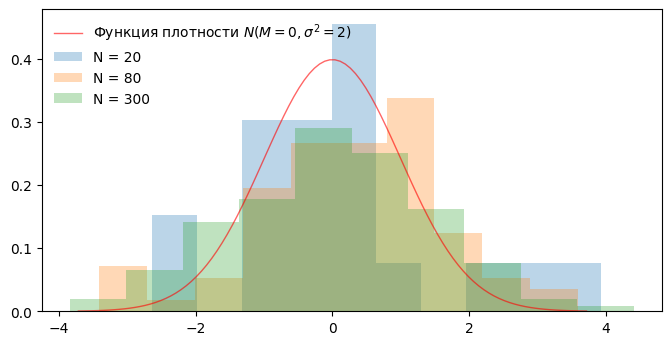

In [ ]:
#ppf - percent point function (inverse of cdf — percentiles)
#cdf - cumulative distribution function
#pdf - probability density function
fig, ax = plt.subplots(1, 1)
points = np.linspace(norm.ppf(0.0001),
                norm.ppf(0.9999), 100)
ax.plot(points, norm.pdf(points),
       'r-', lw=1, alpha=0.6, label=r'Функция плотности $N(M=0,\sigma^2=2)$')
for i in range(len(err_arr)):
  ax.hist(x=err_arr[i], density=True, alpha=0.3, label = 'N = '+str(N_arr[i]))
ax.legend(loc='upper left', frameon=False)
plt.show()

##Входы

In [ ]:
U_N_matr = []
for i in range(len(N_arr)):
  U_matr = [np.full((N_arr[i],),1)]
  for j in range(c_len-1):
    U_matr.append(norm.rvs(loc=0, scale=5,size=N_arr[i]))
  U_N_matr.append(np.transpose(U_matr))

In [ ]:
U_N_matr[0].shape

(20, 4)

##Выходы

In [ ]:
y_N_matr = []
for i in range(len(N_arr)):
  y_N_matr.append(np.matmul(U_N_matr[i],c)+err_arr[i])

In [ ]:
y_N_matr[1].shape

(80,)

##Вычисление оценок вектора парметров
$$c = [4.52942262, 1.99049039, 1.48374341, 1.50604236]$$

In [ ]:
c_est = []
for i in range(len(N_arr)):
  exp = RecurrentMLS(100)
  exp.fit(U_N_matr[i], y_N_matr[i], np.array([4.1, 1.5, 1., 0.]))
  c_est.append(exp.get_coefs()[N_arr[i]])
  print(N_arr[i],": ",c_est[i],sep='')

20: [3.77484604 1.776106   1.41712809 1.70377629]
80: [4.73830965 1.97978311 1.46634899 1.49903264]
300: [4.49984603 2.00117247 1.50144857 1.51838585]


Что получится нерекуррентным МНК?

In [ ]:
for i in range(len(N_arr)):
  print(N_arr[i],": ",nonRecLS(U_N_matr[i],np.eye(N_arr[i]),y_N_matr[i]),sep='')

20: [4.76970577 1.9531101  1.56346556 1.53664951]
80: [4.84535609 1.9917449  1.47346633 1.50345405]
300: [4.54009235 2.00404417 1.49508806 1.52103779]


###Визуализация результатов оценки параметров рекуррентным МНК

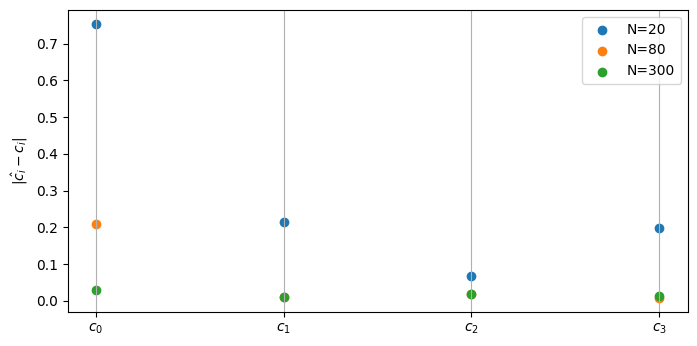

In [ ]:
coef_n = [r'$c_0$',r'$c_1$',r'$c_2$',r'$c_3$']
for i in range(len(N_arr)):
  plt.scatter(coef_n, abs(c_est[i]-c), label=r'N='+str(N_arr[i]))
plt.xticks(coef_n)
plt.grid(axis='x')
plt.ylabel(r'$|\hat{c_i}-c_i|$')
plt.legend(loc='best')
None

In [ ]:
for i in range(len(N_arr)):
  penalty = 0
  for j in range(c_len):
    delta = abs(c[j]-c_est[i][j])
    penalty += delta**2
    penalty /= c_len
  print("Функция штрафа при N = {0}:\t{1:5.3}".format(N_arr[i], penalty))

Функция штрафа при N = 20:	0.013
Функция штрафа при N = 80:	0.000203
Функция штрафа при N = 300:	6.29e-05
